# Free, Mass-Loaded Bar

## Eigenvalue Problem (finding the natural frequencies)

  Mass ratio m/m_b = 1
  Mode n     z_n = k_n L    k_n L / pi
----------------------------------------------------
  n = 1        2.02875784      0.645774
  n = 2        4.91318044      1.563914
  n = 3        7.97866571      2.539688
  n = 4       11.08553841      3.528636
  n = 5       14.20743673      4.522368
  n = 6       17.33637792      5.518340


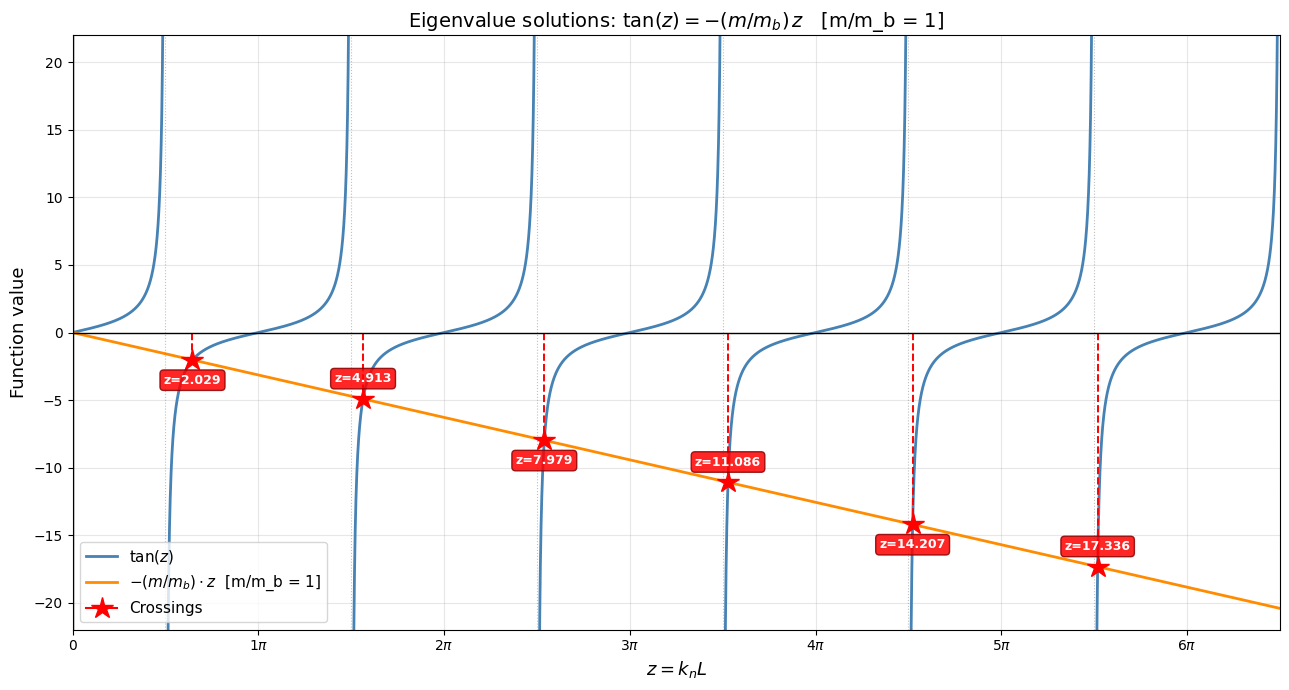

In [11]:
# ============================================================
# Free Mass-Loaded Bar — Eigenvalue Equation
# tan(z) = -(m/m_b) * z,  z = k_n L
# For m = m_b:  tan(z) + z = 0
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# ------------------------------------------------------------
# Parameters
# ------------------------------------------------------------
mass_ratio = 1    # m / m_b
num_modes  = 6

# ------------------------------------------------------------
# 1. Transcendental equation
# ------------------------------------------------------------
def f(z, mr):
    return np.tan(z) + mr * z

# ------------------------------------------------------------
# 2. Root finding — search BOTH halves of every tan branch
#    tan(z) has a pole at (n+0.5)*pi, so each period (n*pi, (n+1)*pi)
#    is split into two sub-intervals around the pole.
# ------------------------------------------------------------
roots = []
n = 0
while len(roots) < num_modes:
    for (a, b) in [
        (n * np.pi + 1e-9,           (n + 0.5) * np.pi - 1e-9),
        ((n + 0.5) * np.pi + 1e-9,  (n + 1.0) * np.pi - 1e-9)
    ]:
        try:
            fa, fb = f(a, mass_ratio), f(b, mass_ratio)
            if fa * fb < 0:
                root = brentq(f, a, b, args=(mass_ratio,), xtol=1e-12)
                if root > 1e-3 and all(abs(root - r) > 1e-3 for r in roots):
                    roots.append(root)
        except Exception:
            pass
    n += 1
    if n > 200:
        break

roots = np.array(sorted(roots)[:num_modes])

# Print table
print("=" * 52)
print(f"  Mass ratio m/m_b = {mass_ratio}")
print("=" * 52)
print(f"{'Mode n':>8}  {'z_n = k_n L':>14}  {'k_n L / pi':>12}")
print("-" * 52)
for i, r in enumerate(roots):
    print(f"  n = {i+1}    {r:>14.8f}    {r/np.pi:>10.6f}")
print("=" * 52)

# ------------------------------------------------------------
# 3. Build curves
# ------------------------------------------------------------
z_max = (num_modes + 0.5) * np.pi
z = np.linspace(1e-6, z_max, 10000)
tan_z = np.tan(z)

# Mask discontinuities at poles
big_jump = np.abs(np.diff(tan_z)) > 50
tan_z_masked = tan_z.copy()
tan_z_masked[:-1][big_jump] = np.nan

line_z = -mass_ratio * z

# ------------------------------------------------------------
# 4. Plot
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(13, 7))

ax.plot(z, tan_z_masked, color='steelblue', lw=2, label=r'$\tan(z)$')
ax.plot(z, line_z,       color='darkorange', lw=2,
        label=fr'$-(m/m_b)\cdot z$  [m/m_b = {mass_ratio}]')

# ---- Crossings: star + vertical line + text box ----
for i, r in enumerate(roots):
    yr = -mass_ratio * r          # y-coordinate of crossing

    # vertical line from x-axis up/down to the crossing point
    ax.plot([r, r], [0, yr], color='red', lw=1.4, ls='--')

    # large star AT the crossing
    ax.plot(r, yr, marker='*', color='red', ms=16, zorder=10,
            label='Crossings' if i == 0 else '_nolegend_')

    # text label: stagger alternate roots up/down to avoid overlap
    y_text = yr - 1.5 if (i % 2 == 0) else yr + 1.5
    ax.text(r, y_text,
            f'z={r:.3f}',
            fontsize=9, color='white', fontweight='bold',
            ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='red',
                      edgecolor='darkred', alpha=0.85),
            zorder=11)

# Reference lines and asymptotes
ax.axhline(0, color='k', lw=1.0)
ax.axvline(0, color='k', lw=1.0)
for k in range(1, num_modes + 2):
    ax.axvline((k - 0.5) * np.pi, color='gray', lw=0.8, ls=':', alpha=0.5)

# Axes formatting
ax.set_xlim(0, z_max)
ax.set_ylim(-22, 22)
ax.set_xlabel(r'$z = k_n L$', fontsize=13)
ax.set_ylabel('Function value', fontsize=13)
ax.set_title(
    fr'Eigenvalue solutions: $\tan(z) = -(m/m_b)\,z$   [m/m_b = {mass_ratio}]',
    fontsize=14
)
ax.legend(fontsize=11, loc='lower left')
ax.grid(True, alpha=0.3)

# x-axis ticks in units of pi
pi_ticks = np.arange(0, num_modes + 1) * np.pi
ax.set_xticks(pi_ticks)
ax.set_xticklabels(
    [r'$0$'] + [fr'${k}\pi$' for k in range(1, num_modes + 1)],
    fontsize=10
)

plt.tight_layout()
plt.savefig('massloaded_bar_eigenvalues.png', dpi=150, bbox_inches='tight')
plt.show()


## Eigenfunctions/Mode shapes

  L = 1.0,  m/m_b = 1.0
   n    z_n = k_nL           k_n
---------------------------------------------
   1      2.028758      2.028758
   2      4.913180      4.913180
   3      7.978666      7.978666
   4     11.085538     11.085538
   5     14.207437     14.207437
   6     17.336378     17.336378


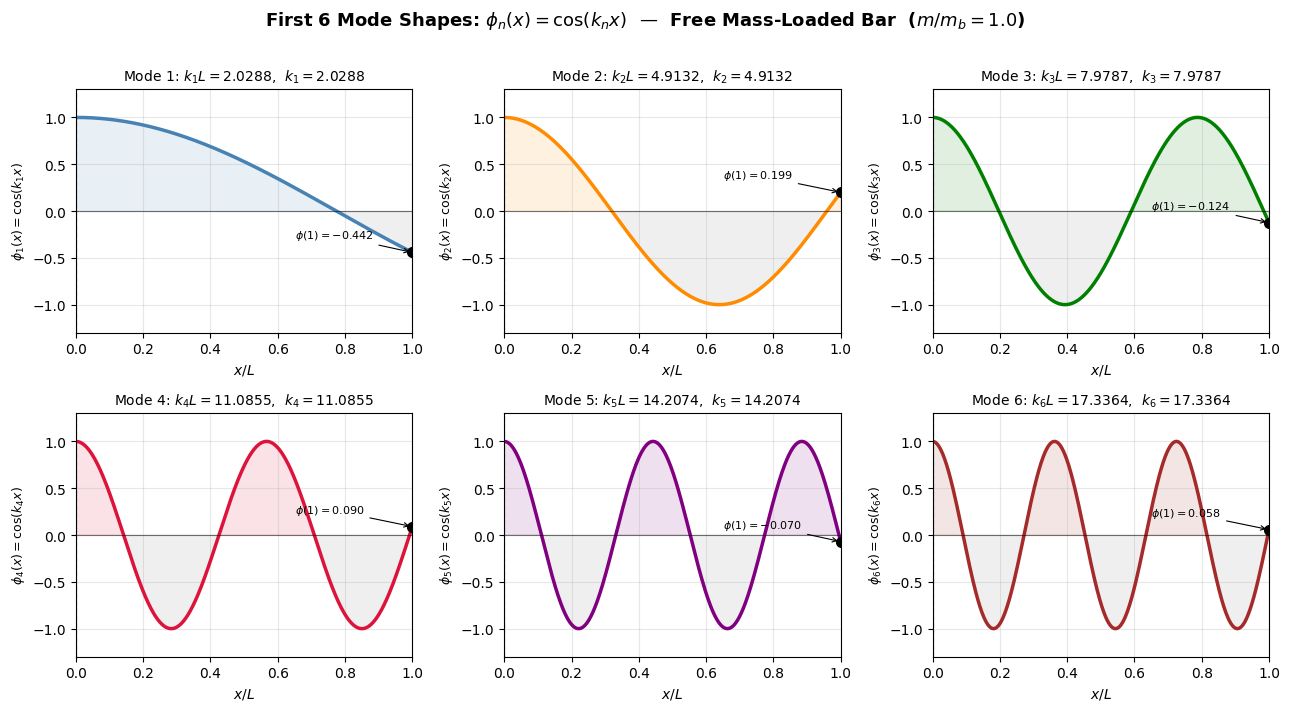

In [21]:
# ============================================================
# Free Mass-Loaded Bar — First 6 Mode Shapes
# Mode shape: phi_n(x) = cos(k_n * x)
# k_n = z_n / L,  where z_n are roots of tan(z) + (m/m_b)*z = 0
# Assume L = 1 (unit bar), m = m_b
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# ------------------------------------------------------------
# 1. Parameters
# ------------------------------------------------------------
mass_ratio = 1.0    # m / m_b
num_modes  = 6
L          = 1.0    # bar length (normalised)

# ------------------------------------------------------------
# 2. Find roots z_n = k_n * L (same as before)
# ------------------------------------------------------------
def f(z, mr):
    return np.tan(z) + mr * z

roots = []
n = 0
while len(roots) < num_modes:
    for (a, b) in [
        (n * np.pi + 1e-9,          (n + 0.5) * np.pi - 1e-9),
        ((n + 0.5) * np.pi + 1e-9,  (n + 1.0) * np.pi - 1e-9)
    ]:
        try:
            fa, fb = f(a, mass_ratio), f(b, mass_ratio)
            if fa * fb < 0:
                root = brentq(f, a, b, args=(mass_ratio,), xtol=1e-12)
                if root > 1e-3 and all(abs(root - r) > 1e-3 for r in roots):
                    roots.append(root)
        except Exception:
            pass
    n += 1
    if n > 200:
        break

roots = np.array(sorted(roots)[:num_modes])
kn    = roots / L    # k_n values

print("=" * 45)
print(f"  L = {L},  m/m_b = {mass_ratio}")
print("=" * 45)
print(f"{'n':>4}  {'z_n = k_nL':>12}  {'k_n':>12}")
print("-" * 45)
for i, (z, k) in enumerate(zip(roots, kn)):
    print(f"  {i+1:>2}  {z:>12.6f}  {k:>12.6f}")
print("=" * 45)

# ------------------------------------------------------------
# 3. Plot all 6 mode shapes in one figure (subplots)
# ------------------------------------------------------------
x = np.linspace(0, L, 500)

fig, axes = plt.subplots(2, 3, figsize=(13, 7), sharey=False)
axes = axes.flatten()

colors = ['steelblue', 'darkorange', 'green',
          'crimson',   'purple',     'brown']

for i, (k, color) in enumerate(zip(kn, colors)):
    phi = np.cos(k * x)          # mode shape

    ax = axes[i]
    ax.plot(x, phi, color=color, lw=2.5)

    # Mark the value at x = L (the loaded end)
    ax.plot(L, np.cos(k * L), 'ko', ms=7, zorder=5)
    ax.annotate(fr'$\phi({L:.0f})={np.cos(k*L):.3f}$',
                xy=(L, np.cos(k * L)),
                xytext=(0.65, np.cos(k * L) + 0.15),
                fontsize=8, color='black',
                arrowprops=dict(arrowstyle='->', color='black', lw=0.8))

    # Mark the fixed end x = 0
    ax.axvline(0, color='gray', lw=1.0, ls='--', alpha=0.6)

    ax.axhline(0, color='k', lw=0.8, ls='-', alpha=0.5)
    ax.set_xlim(0, L)
    ax.set_ylim(-1.3, 1.3)
    ax.set_title(
        fr'Mode {i+1}: $k_{i+1}L = {roots[i]:.4f}$,  $k_{i+1} = {k:.4f}$',
        fontsize=10
    )
    ax.set_xlabel(r'$x / L$', fontsize=10)
    ax.set_ylabel(fr'$\phi_{i+1}(x) = \cos(k_{i+1}x)$', fontsize=9)
    ax.grid(True, alpha=0.3)

    # Shade regions above/below zero
    ax.fill_between(x, phi, 0,
                    where=(phi >= 0), alpha=0.12, color=color)
    ax.fill_between(x, phi, 0,
                    where=(phi <  0), alpha=0.12, color='gray')

fig.suptitle(
    fr'First 6 Mode Shapes: $\phi_n(x) = \cos(k_n x)$'
    fr'  —  Free Mass-Loaded Bar  ($m/m_b = {mass_ratio}$)',
    fontsize=13, fontweight='bold', y=1.01
)

plt.tight_layout()
plt.savefig('mode_shapes.png', dpi=150, bbox_inches='tight')
plt.show()


## First mode - Animation

In [18]:
# ============================================================
# Free Mass-Loaded Bar — Animated First Mode Shape
# phi_1(x, t) = cos(k_1 * x) * cos(omega_1 * t)
# k_1 = z_1 / L,  z_1 = root of tan(z) + (m/m_b)*z = 0
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.optimize import brentq
from IPython.display import HTML

# ------------------------------------------------------------
# 1. Parameters
# ------------------------------------------------------------
mass_ratio  = 1.0
L           = 1.0
omega1      = 1.0
num_frames  = 80
interval_ms = 40

# ------------------------------------------------------------
# 2. Find z_1 = k_1 * L
# ------------------------------------------------------------
def f(z, mr):
    return np.tan(z) + mr * z

def get_first_root(mr):
    for (a, b) in [
        (1e-9,                     0.5 * np.pi - 1e-9),
        (0.5 * np.pi + 1e-9,       1.0 * np.pi - 1e-9)
    ]:
        try:
            fa, fb = f(a, mr), f(b, mr)
            if fa * fb < 0:
                return brentq(f, a, b, args=(mr,), xtol=1e-12)
        except Exception:
            pass
    return None

z1 = get_first_root(mass_ratio)
k1 = z1 / L
x_node = (np.pi / 2) / k1

print(f"  m/m_b  = {mass_ratio}")
print(f"  z_1    = k_1*L = {z1:.6f}")
print(f"  k_1    = {k1:.6f}")
print(f"  Node   @ x/L  = {x_node/L:.4f}")

# ------------------------------------------------------------
# 3. Spatial grid and time array
# ------------------------------------------------------------
x      = np.linspace(0, L, 500)
T      = 2 * np.pi / omega1
t_vals = np.linspace(0, T, num_frames, endpoint=False)
phi_x  = np.cos(k1 * x)

# ------------------------------------------------------------
# 4. Set up figure
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 5))

# Static elements
ax.axhline(0,      color='k',      lw=0.9, ls='-')
ax.axvline(0,      color='gray',   lw=3.0, ls='-', alpha=0.9,
           label='Fixed end (x=0)')                      # thick line only, no hatches
ax.axvline(x_node, color='purple', lw=1.2, ls='--', alpha=0.7,
           label=fr'Node  $x/L = {x_node/L:.3f}$')

# Tip mass rectangle at x = L
tip_patch = plt.Rectangle((L, -0.12), 0.04, 0.24,
                           color='navy', zorder=6)
ax.add_patch(tip_patch)
ax.text(L + 0.06, 0,
        r'$m$ (tip mass)',
        fontsize=9, va='center', color='navy')

# Animated objects
line, = ax.plot([], [], color='steelblue', lw=2.5, zorder=5)

time_text = ax.text(0.02, 0.92, '', transform=ax.transAxes,
                    fontsize=11, color='darkred',
                    bbox=dict(boxstyle='round', facecolor='lightyellow',
                              edgecolor='red', alpha=0.8))

phase_text = ax.text(0.75, 0.92, '', transform=ax.transAxes,
                     fontsize=10, color='darkblue',
                     bbox=dict(boxstyle='round', facecolor='lightcyan',
                               edgecolor='blue', alpha=0.8))

ax.set_xlim(-0.05, L + 0.25)
ax.set_ylim(-1.4,  1.4)
ax.set_xlabel(r'$x / L$', fontsize=12)
ax.set_ylabel(r'$\phi_1(x,\,t)$', fontsize=12)
ax.set_title(
    fr'Mode 1 Animation:  $\phi_1(x,t) = \cos(k_1 x)\cos(\omega_1 t)$'
    fr'   —   $m/m_b = {mass_ratio}$,  $k_1 L = {z1:.4f}$',
    fontsize=11
)
ax.legend(fontsize=10, loc='lower right')
ax.grid(True, alpha=0.3)

# ------------------------------------------------------------
# 5. Animation functions
# ------------------------------------------------------------
def init():
    line.set_data([], [])
    time_text.set_text('')
    phase_text.set_text('')
    return line, time_text, phase_text

def animate(frame):
    t     = t_vals[frame]
    amp   = np.cos(omega1 * t)
    phi_t = phi_x * amp

    line.set_data(x / L, phi_t)

    # Move tip mass with bar end
    tip_patch.set_y(phi_t[-1] - 0.12)

    # Refresh shaded fills
    for coll in ax.collections:
        coll.remove()

    ax.fill_between(x / L, 0, phi_t,
                    where=(phi_t >= 0),
                    alpha=0.15, color='steelblue')
    ax.fill_between(x / L, 0, phi_t,
                    where=(phi_t <  0),
                    alpha=0.15, color='orange')

    # Re-draw node dot (removed with collections above)
    ax.plot(x_node / L, 0, 'o',
            color='purple', ms=9, zorder=7)

    time_text.set_text(fr'$t = {t:.3f}$ s')
    phase_text.set_text(fr'$\cos(\omega_1 t) = {amp:+.3f}$')

    return line, time_text, phase_text

# ------------------------------------------------------------
# 6. Run and display
# ------------------------------------------------------------
ani = animation.FuncAnimation(
    fig,
    animate,
    frames=num_frames,
    init_func=init,
    interval=interval_ms,
    blit=False
)

plt.tight_layout()
HTML(ani.to_jshtml())


Output hidden; open in https://colab.research.google.com to view.

## Node migration with mass ratio - First mode

       m/m_b    z_1 = k_1L      Node x/L
-------------------------------------------------------
       0.010      3.110498      0.504998
       0.100      2.862773      0.548698
       0.500      2.288930      0.686258
       1.000      2.028758      0.774265
       2.000      1.836597      0.855275
       5.000      1.688683      0.930190
      10.000      1.631995      0.962501
      50.000      1.583426      0.992024
     100.000      1.577137      0.995980


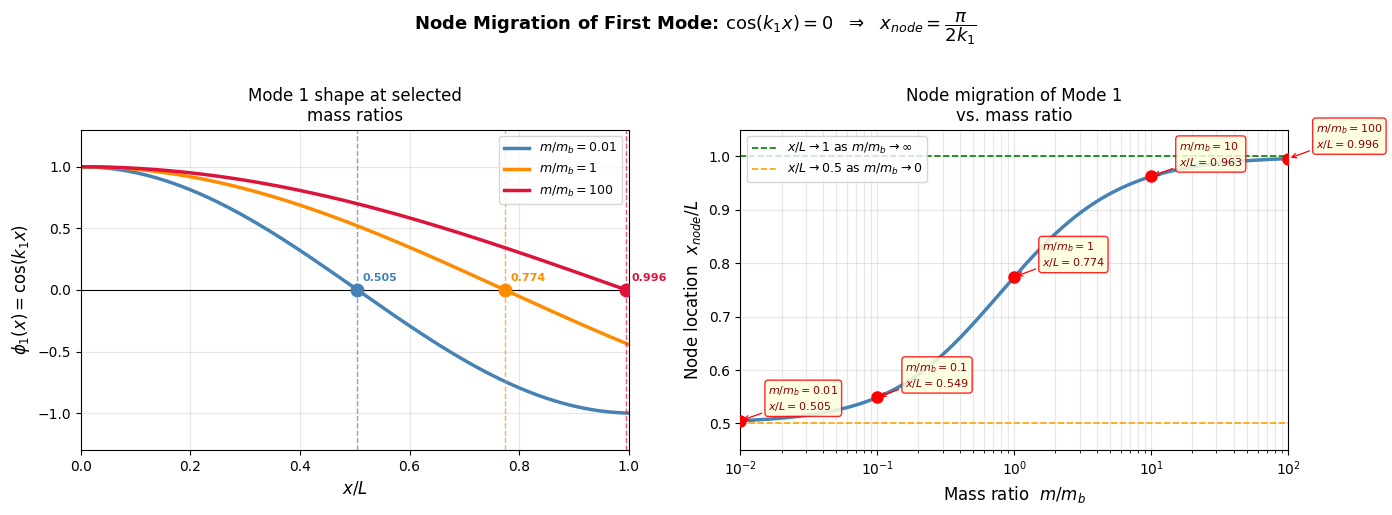

In [23]:
# ============================================================
# Free Mass-Loaded Bar — Node Migration of Mode 1
# Node of phi_1(x) = cos(k_1 x) is at x = pi / (2 * k_1)
# k_1 = z_1 / L,  z_1 = root of tan(z) + (m/m_b)*z = 0
# We sweep mass ratio m/m_b from 0.01 to 100
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# ------------------------------------------------------------
# 1. Setup
# ------------------------------------------------------------
L           = 1.0
num_ratios  = 500
mass_ratios = np.logspace(-2, 2, num_ratios)   # 0.01 → 100, log-spaced

# ------------------------------------------------------------
# 2. Transcendental equation
# ------------------------------------------------------------
def f(z, mr):
    return np.tan(z) + mr * z

def get_first_root(mr):
    for (a, b) in [
        (1e-9,                     0.5 * np.pi - 1e-9),
        (0.5 * np.pi + 1e-9,       1.0 * np.pi - 1e-9)
    ]:
        try:
            fa, fb = f(a, mr), f(b, mr)
            if fa * fb < 0:
                return brentq(f, a, b, args=(mr,), xtol=1e-12)
        except Exception:
            pass
    return None

# ------------------------------------------------------------
# 3. Sweep mass ratio and compute node location
# ------------------------------------------------------------
z1_vals   = []
node_vals = []

for mr in mass_ratios:
    z1 = get_first_root(mr)
    if z1 is not None:
        k1   = z1 / L
        node = (np.pi / 2) / k1
        z1_vals.append(z1)
        node_vals.append(node)
    else:
        z1_vals.append(np.nan)
        node_vals.append(np.nan)

z1_vals   = np.array(z1_vals)
node_vals = np.array(node_vals)

# ------------------------------------------------------------
# 4. Print values at key mass ratios
# ------------------------------------------------------------
key_ratios = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 50.0, 100.0]
print("=" * 55)
print(f"  {'m/m_b':>10}  {'z_1 = k_1L':>12}  {'Node x/L':>12}")
print("-" * 55)
for mr in key_ratios:
    z1 = get_first_root(mr)
    if z1:
        node = (np.pi / 2) / (z1 / L)
        print(f"  {mr:>10.3f}  {z1:>12.6f}  {node/L:>12.6f}")
print("=" * 55)

# ------------------------------------------------------------
# 5. Plot — LEFT: mode shapes, RIGHT: node migration
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ── LEFT panel: mode shapes at 3 selected mass ratios ───────
ax1 = axes[0]                          # <-- SWAPPED
selected = [(0.01, 'steelblue',  r'$m/m_b = 0.01$'),
            (1.0,  'darkorange', r'$m/m_b = 1$'),
            (100.0,'crimson',    r'$m/m_b = 100$')]

x = np.linspace(0, L, 500)

for mr, color, lbl in selected:
    z1   = get_first_root(mr)
    k1   = z1 / L
    phi  = np.cos(k1 * x)
    node = (np.pi / 2) / k1

    ax1.plot(x / L, phi, color=color, lw=2.5, label=lbl)

    ax1.axvline(node / L, color=color, lw=1.0, ls='--', alpha=0.7)
    ax1.plot(node / L, 0, marker='o', color=color, ms=9, zorder=6)
    ax1.text(node / L + 0.01, 0.07,
             f'{node/L:.3f}',
             fontsize=8, color=color, fontweight='bold')

ax1.axhline(0, color='k', lw=0.8)
ax1.set_xlim(0, 1)
ax1.set_ylim(-1.3, 1.3)
ax1.set_xlabel(r'$x / L$', fontsize=12)
ax1.set_ylabel(r'$\phi_1(x) = \cos(k_1 x)$', fontsize=12)
ax1.set_title('Mode 1 shape at selected\nmass ratios', fontsize=12)
ax1.legend(fontsize=9, loc='upper right')
ax1.grid(True, alpha=0.3)

# ── RIGHT panel: node position vs mass ratio ────────────────
ax2 = axes[1]                          # <-- SWAPPED
ax2.semilogx(mass_ratios, node_vals / L, color='steelblue', lw=2.5)

highlight_mrs    = [0.01, 0.1, 1.0, 10.0, 100.0]
highlight_labels = ['0.01', '0.1', '1', '10', '100']
for mr, lbl in zip(highlight_mrs, highlight_labels):
    z1   = get_first_root(mr)
    node = (np.pi / 2) / (z1 / L)
    ax2.plot(mr, node / L, 'ro', ms=8, zorder=5)
    ax2.annotate(
        fr'$m/m_b={lbl}$' + f'\n$x/L={node/L:.3f}$',
        xy=(mr, node / L),
        xytext=(mr * 1.6, node / L + 0.02),
        fontsize=8, color='darkred',
        bbox=dict(boxstyle='round,pad=0.3',
                  facecolor='lightyellow', edgecolor='red', alpha=0.85),
        arrowprops=dict(arrowstyle='->', color='red', lw=0.9)
    )

ax2.axhline(1.0, color='green',  lw=1.2, ls='--',
            label=r'$x/L \to 1$ as $m/m_b \to \infty$')
ax2.axhline(0.5, color='orange', lw=1.2, ls='--',
            label=r'$x/L \to 0.5$ as $m/m_b \to 0$')

ax2.set_xlim(0.01, 100)
ax2.set_ylim(0.45, 1.05)
ax2.set_xlabel(r'Mass ratio  $m / m_b$', fontsize=12)
ax2.set_ylabel(r'Node location  $x_{node} / L$', fontsize=12)
ax2.set_title('Node migration of Mode 1\nvs. mass ratio', fontsize=12)
ax2.legend(fontsize=9, loc='upper left')
ax2.grid(True, which='both', alpha=0.3)

fig.suptitle(
    r'Node Migration of First Mode: $\cos(k_1 x) = 0$  $\Rightarrow$  '
    r'$x_{node} = \dfrac{\pi}{2k_1}$',
    fontsize=13, fontweight='bold', y=1.02
)

plt.tight_layout()
plt.savefig('node_migration.png', dpi=150, bbox_inches='tight')
plt.show()
